# Projet 7 : Implémentez un modèle de scoring 

In [3]:
#imports 
import pandas as pd

from analysis_cleaning_functions import *
import gc
import numpy as np
from numpy import array
from numpy import argmax

import os
import datetime
import time
import random
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
   
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

## Data loading 

In [4]:
#traduire les labels en anglais
directory= "../data/"
df_application_test = pd.read_csv(directory+"application_test.csv", error_bad_lines=False, sep=',')
df_application_train = pd.read_csv(directory+"application_train.csv", error_bad_lines=False, sep=',')
df_bureau= pd.read_csv(directory+'bureau.csv', error_bad_lines=False, sep=',')
df_bureau_balance = pd.read_csv(directory+'bureau_balance.csv', error_bad_lines=False, sep=',')
df_credit_card_balance = pd.read_csv(directory+"credit_card_balance.csv", error_bad_lines=False, sep=',')
df_installments_payments = pd.read_csv(directory+"installments_payments.csv", error_bad_lines=False, sep=',')
df_POS_CASH_balance = pd.read_csv(directory+"POS_CASH_balance.csv", error_bad_lines=False, sep=',')
df_previous_application = pd.read_csv(directory+"previous_application.csv", error_bad_lines=False, sep=',')
df_sample_submission = pd.read_csv(directory+"sample_submission.csv", error_bad_lines=False, sep=',')

df_file_list= [df_application_test, df_application_train, df_bureau, df_bureau_balance, df_credit_card_balance, df_installments_payments, df_POS_CASH_balance, df_previous_application, df_sample_submission]

## Data discovery

In [5]:
df_application_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_application_train.shape

(307511, 122)

In [7]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [8]:
primary_keys = column_with_type (df_application_train, 'SK_ID')

In [9]:
get_dtypes(df_application_train)

int64
int64
object
object
object
object
int64
float64
float64
float64
float64
object
object
object
object
object
float64
int64
int64
float64
int64
float64
int64
int64
int64
int64
int64
int64
object
float64
int64
int64
object
int64
int64
int64
int64
int64
int64
int64
object
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
object
object
float64
object
object
float64
float64
float64
float64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
float64
float64
float64
float64
float64
float64


In [10]:
df_application_test.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,100042,Cash loans,F,Y,Y,0,270000.0,959688.0,34600.5,810000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
6,100057,Cash loans,M,Y,Y,2,180000.0,499221.0,22117.5,373500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,100065,Cash loans,M,N,Y,0,166500.0,180000.0,14220.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
8,100066,Cash loans,F,N,Y,0,315000.0,364896.0,28957.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
9,100067,Cash loans,F,Y,Y,1,162000.0,45000.0,5337.0,45000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [11]:
df_application_test.shape

(48744, 121)

In [12]:
df_application_test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


In [13]:
null_ratio(df_application_train)

Valeurs nulles: 9152465
Valeurs non nulles : 28363877
Pourcentage des valeurs nulles : 24.395941907129433%


In [14]:
null_ratio(df_application_test)

Valeurs nulles: 1404419
Valeurs non nulles : 4493605
Pourcentage des valeurs nulles : 23.811686761532336%


In [15]:
print(df_application_train['FLAG_OWN_CAR'].unique())

['N' 'Y']


In [16]:
print("train dataset ")
to_keep = missing_percentage_variable(df_application_train, 70)
print('Test dataset ')
to_keep_1 = missing_percentage_variable(df_application_test, 70)
#get intersection
final_columns = [value for value in to_keep_1 if value in to_keep]

train dataset 
SK_ID_CURR > Missing values : 0 (0.0%)
TARGET > Missing values : 0 (0.0%)
NAME_CONTRACT_TYPE > Missing values : 0 (0.0%)
CODE_GENDER > Missing values : 0 (0.0%)
FLAG_OWN_CAR > Missing values : 0 (0.0%)
FLAG_OWN_REALTY > Missing values : 0 (0.0%)
CNT_CHILDREN > Missing values : 0 (0.0%)
AMT_INCOME_TOTAL > Missing values : 0 (0.0%)
AMT_CREDIT > Missing values : 0 (0.0%)
AMT_ANNUITY > Missing values : 12 (0.0%)
AMT_GOODS_PRICE > Missing values : 278 (0.1%)
NAME_TYPE_SUITE > Missing values : 1292 (0.4%)
NAME_INCOME_TYPE > Missing values : 0 (0.0%)
NAME_EDUCATION_TYPE > Missing values : 0 (0.0%)
NAME_FAMILY_STATUS > Missing values : 0 (0.0%)
NAME_HOUSING_TYPE > Missing values : 0 (0.0%)
REGION_POPULATION_RELATIVE > Missing values : 0 (0.0%)
DAYS_BIRTH > Missing values : 0 (0.0%)
DAYS_EMPLOYED > Missing values : 0 (0.0%)
DAYS_REGISTRATION > Missing values : 0 (0.0%)
DAYS_ID_PUBLISH > Missing values : 0 (0.0%)
OWN_CAR_AGE > Missing values : 202929 (66.0%)
FLAG_MOBIL > Missing v

HOUSETYPE_MODE > Missing values : 23619 (48.5%)
TOTALAREA_MODE > Missing values : 22624 (46.4%)
WALLSMATERIAL_MODE > Missing values : 23893 (49.0%)
EMERGENCYSTATE_MODE > Missing values : 22209 (45.6%)
OBS_30_CNT_SOCIAL_CIRCLE > Missing values : 29 (0.1%)
DEF_30_CNT_SOCIAL_CIRCLE > Missing values : 29 (0.1%)
OBS_60_CNT_SOCIAL_CIRCLE > Missing values : 29 (0.1%)
DEF_60_CNT_SOCIAL_CIRCLE > Missing values : 29 (0.1%)
DAYS_LAST_PHONE_CHANGE > Missing values : 0 (0.0%)
FLAG_DOCUMENT_2 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_3 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_4 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_5 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_6 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_7 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_8 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_9 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_10 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_11 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_12 > Missing values : 0 (0.0%)
FLAG_DOCUMENT_13 > Missing values : 0 (0.0%)


In [17]:
train, test = remove_missing_columns(df_application_train, df_application_test, 70)

There are 0 columns with greater than 70% missing values.


In [18]:
train = transform_flag_variables (train)
test = transform_flag_variables (test)

FLAG_OWN_CAR
[0. 1.]
FLAG_OWN_REALTY
[1. 0.]
FLAG_MOBIL
[1 0]
FLAG_EMP_PHONE
[1 0]
FLAG_WORK_PHONE
[0 1]
FLAG_CONT_MOBILE
[1 0]
FLAG_PHONE
[1 0]
FLAG_EMAIL
[0 1]
FLAG_DOCUMENT_2
[0 1]
FLAG_DOCUMENT_3
[1 0]
FLAG_DOCUMENT_4
[0 1]
FLAG_DOCUMENT_5
[0 1]
FLAG_DOCUMENT_6
[0 1]
FLAG_DOCUMENT_7
[0 1]
FLAG_DOCUMENT_8
[0 1]
FLAG_DOCUMENT_9
[0 1]
FLAG_DOCUMENT_10
[0 1]
FLAG_DOCUMENT_11
[0 1]
FLAG_DOCUMENT_12
[0 1]
FLAG_DOCUMENT_13
[0 1]
FLAG_DOCUMENT_14
[0 1]
FLAG_DOCUMENT_15
[0 1]
FLAG_DOCUMENT_16
[0 1]
FLAG_DOCUMENT_17
[0 1]
FLAG_DOCUMENT_18
[0 1]
FLAG_DOCUMENT_19
[0 1]
FLAG_DOCUMENT_20
[0 1]
FLAG_DOCUMENT_21
[0 1]
FLAG_OWN_CAR
[0. 1.]
FLAG_OWN_REALTY
[1. 0.]
FLAG_MOBIL
[1 0]
FLAG_EMP_PHONE
[1 0]
FLAG_WORK_PHONE
[0 1]
FLAG_CONT_MOBILE
[1 0]
FLAG_PHONE
[0 1]
FLAG_EMAIL
[1 0]
FLAG_DOCUMENT_2
[0]
FLAG_DOCUMENT_3
[1 0]
FLAG_DOCUMENT_4
[0 1]
FLAG_DOCUMENT_5
[0 1]
FLAG_DOCUMENT_6
[0 1]
FLAG_DOCUMENT_7
[0 1]
FLAG_DOCUMENT_8
[0 1]
FLAG_DOCUMENT_9
[0 1]
FLAG_DOCUMENT_10
[0]
FLAG_DOCUMENT_11
[0 1]
FLAG_D

In [19]:
for df in df_file_list :
    convert_types (df)
    
del df_file_list
gc.collect()

4

In [20]:
print(train['FLAG_OWN_CAR'].unique())

[0. 1.]


In [21]:
null_ratio(train)

Valeurs nulles: 9152465
Valeurs non nulles : 28363877
Pourcentage des valeurs nulles : 24.395941907129433%


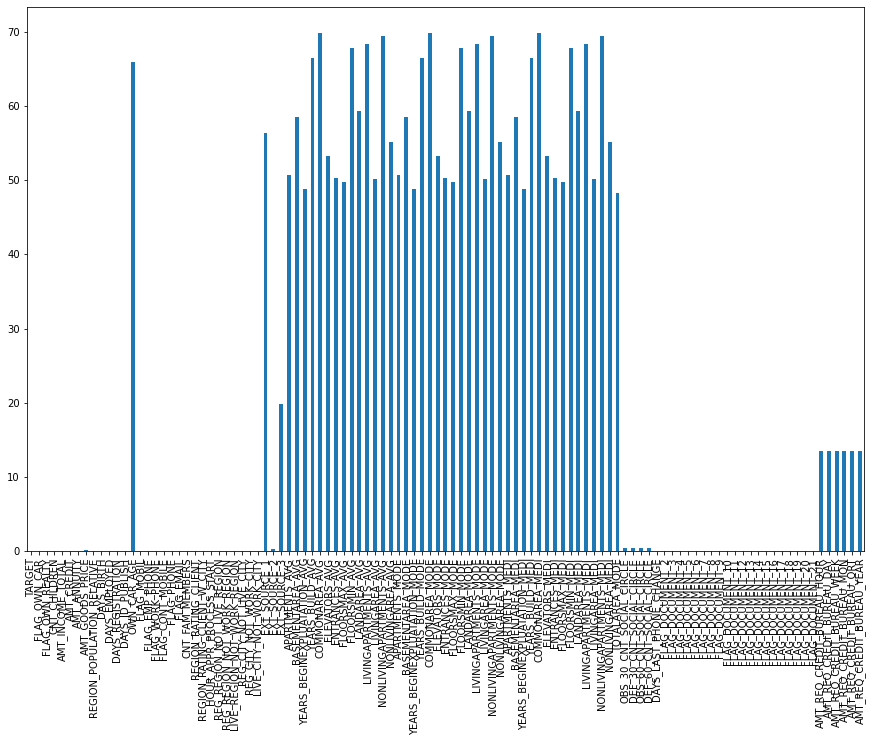

In [22]:
show_null_per_variable(train[get_numerical_categorical(train)[0]])

In [23]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0.0,1.0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,0.0,0.0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,1.0,1.0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,0.0,1.0,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,0.0,1.0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


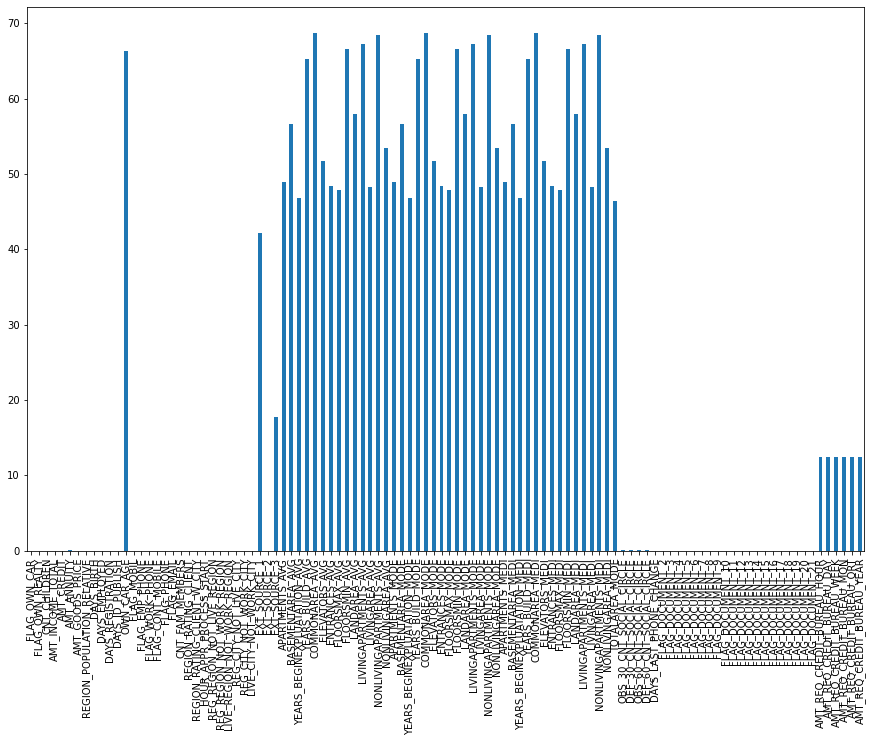

In [24]:
show_null_per_variable(test[get_numerical_categorical(test)[0]])

In [25]:
#numerical features in the dataframe
num_train_columns = get_numerical_categorical(train)[0]
print(num_train_columns)

['SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'Y

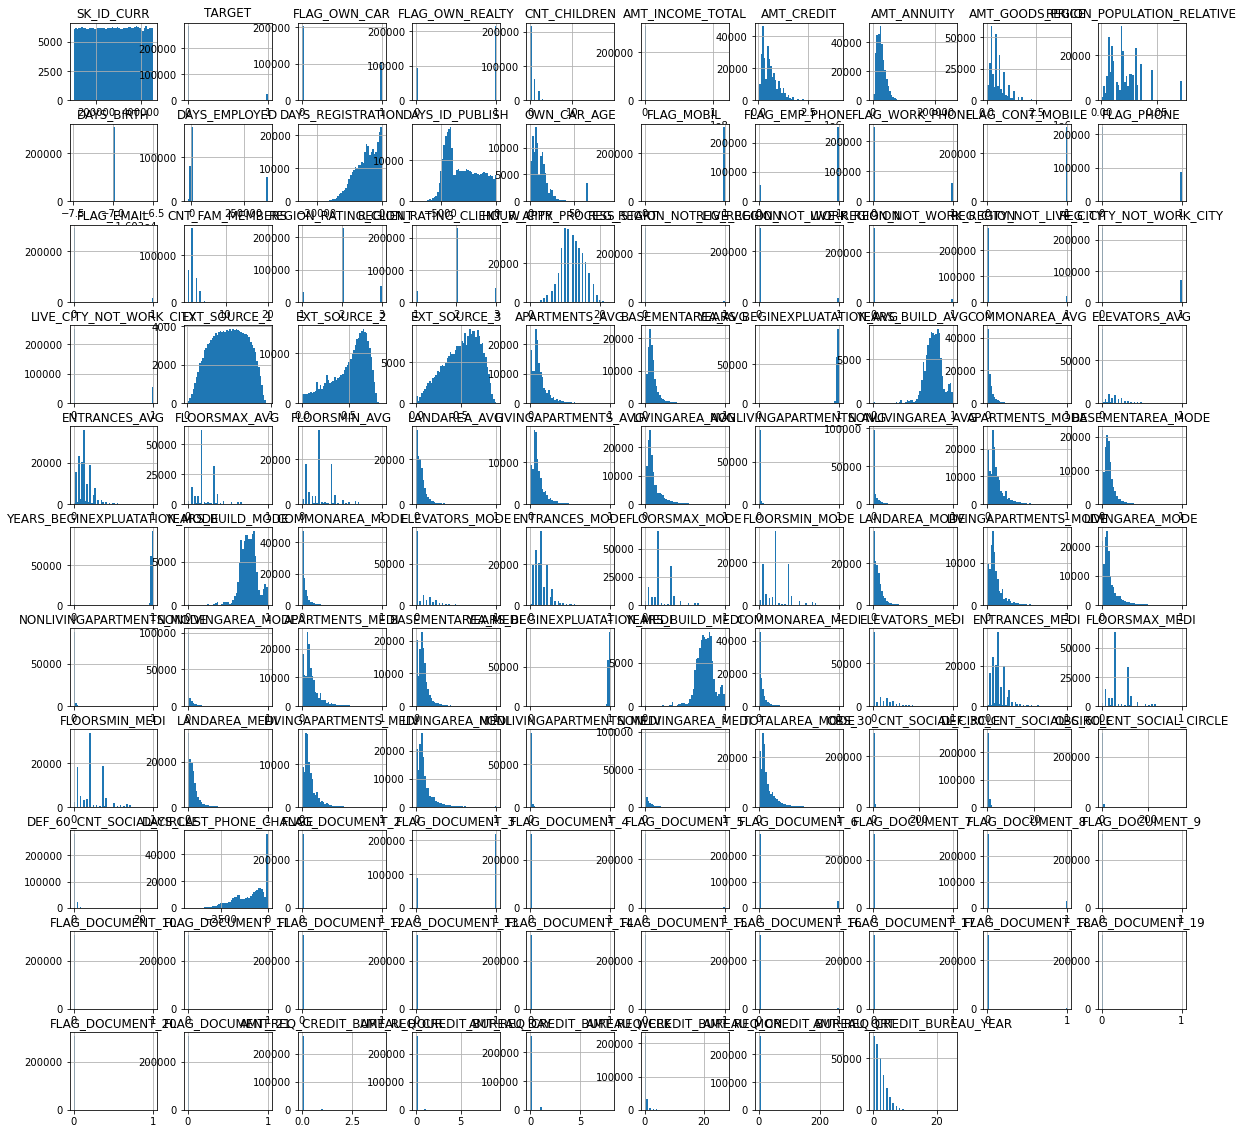

In [26]:
train[num_train_columns].hist(bins=50, figsize= (20,20))
plt.show()

In [27]:
print("remove outliers ")  
def columns_outliers(df, numerical):
    id_columns = []
    for c in numerical :
        #no outliers on income
        if 'SK_ID' in c or c == 'AMT_INCOME_TOTAL':
            id_columns.append(c)
    treated_columns= [ele for ele in numerical if ele not in id_columns]
    return treated_columns
    
def find_remove_outliers(df, treated_columns):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    #remove anomalies
    df =  df[~((df[treated_columns] < (Q1 - 1.5 * IQR)) |(df[treated_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df 
#treated_columns = columns_outliers(train, num_train_columns)
#train = find_remove_outliers(train, treated_columns)
#print(train.shape)

remove outliers 


In [28]:
train[num_train_columns].head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0.0,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0.0,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1.0,1.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0.0,1.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0.0,1.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
train.shape

(307511, 122)

In [30]:
#treated_columns_test = columns_outliers(test, num_test_columns)
#test = find_remove_outliers(test, treated_columns_test)
#print(test.shape)

In [31]:
#numerical features in the dataframe
num_test_columns = get_numerical_categorical(test)[0]
print(num_test_columns)

['SK_ID_CURR', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGIN

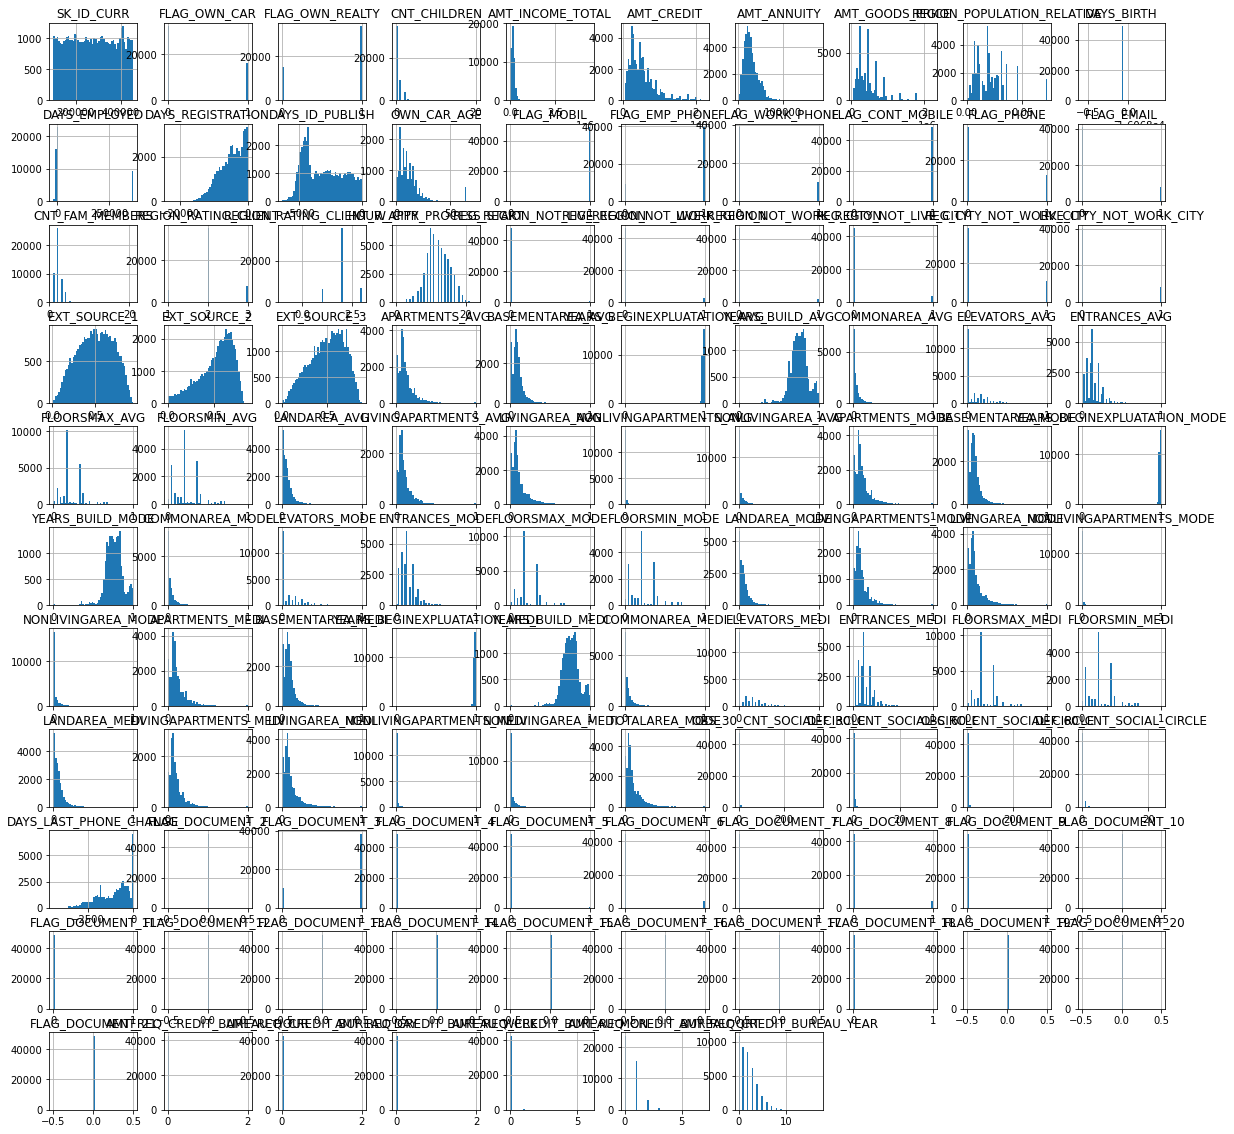

In [32]:
test[num_test_columns].hist(bins=50, figsize= (20,20))
plt.show()

* Le test de Kolmogorov-Smirnov détermine si les observations d'un échantillon peuvent raisonnablement provenir d'une distribution théorique donnée (dont la loi normale)
* Il mesure de l'écart maximum qui existe entre la fonction de répartition observée (ou tout simplement des fréquences cumulées) et la fonction de répartition théorique (normale). 


In [33]:
non_treated_columns = ['SK_ID_CURR', 'TARGET']

In [34]:
cols_log_trans_train = get_non_normal_ditributions_columns (train[num_train_columns], non_treated_columns)

In [35]:
print(cols_log_trans_train)

['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


In [36]:
cols_log_trans_test = get_non_normal_ditributions_columns (test[num_test_columns], non_treated_columns)

In [37]:
test[cols_log_trans_test].head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0.0,1.0,0,135000.0,568800.0,450000.0,0.018850,-16068.084605,-2329,-5170.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0,99000.0,222768.0,180000.0,0.035792,-16068.084605,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,0,202500.0,663264.0,630000.0,0.019101,-16068.084605,-4458,-2175.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,2,315000.0,1575000.0,1575000.0,0.026392,-16068.084605,-1866,-2000.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,1,180000.0,625500.0,625500.0,0.010032,-16068.084605,-2191,-4000.0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# remove variables about LIVING (they are not well filled so if we delete them we will lose a high number of rows)
train, test = remove_missing_columns(train, test, threshold=45 )

There are 49 columns with greater than 45% missing values.


In [39]:
transform_variables_log(train, cols_log_trans_train)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,Log_FLAG_DOCUMENT_12,Log_FLAG_DOCUMENT_13,Log_FLAG_DOCUMENT_14,Log_FLAG_DOCUMENT_15,Log_FLAG_DOCUMENT_16,Log_FLAG_DOCUMENT_17,Log_FLAG_DOCUMENT_18,Log_FLAG_DOCUMENT_19,Log_FLAG_DOCUMENT_20,Log_FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,1129500.0,Family,State servant,Higher education,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,F,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,...,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,F,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,F,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0


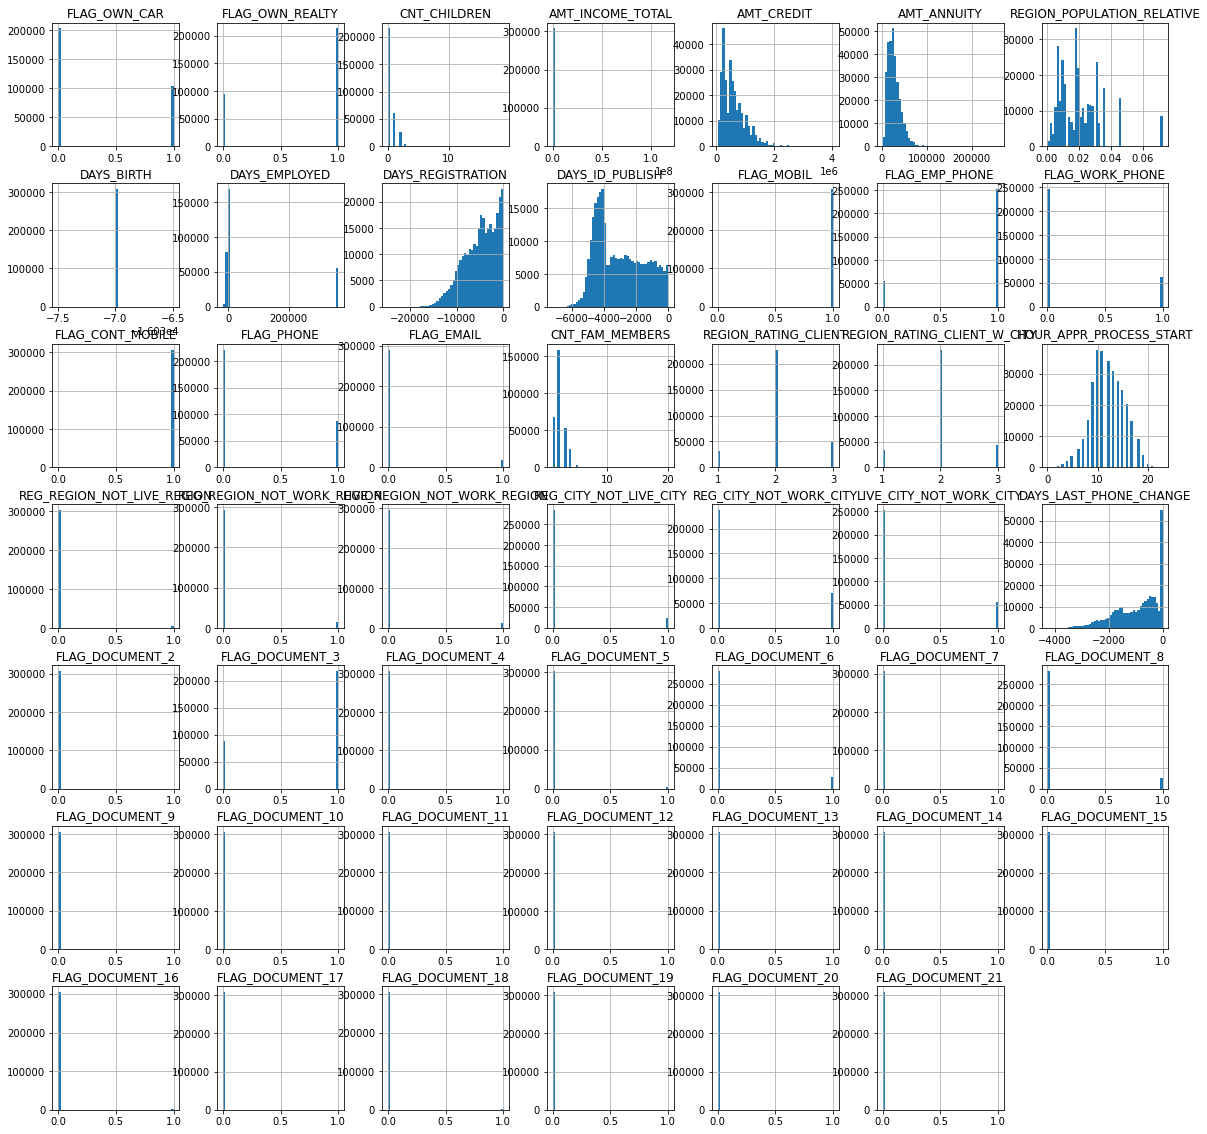

In [40]:
train[cols_log_trans_train].hist(bins=50, figsize= (20,20))
plt.show()

In [41]:
train[cols_log_trans_train].head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0.0,1.0,0,202500.0,406597.5,24700.5,0.018801,-16036.995067,-637,-3648.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0,270000.0,1293502.5,35698.5,0.003541,-16036.995067,-1188,-1186.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,0,67500.0,135000.0,6750.0,0.010032,-16036.995067,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,0,135000.0,312682.5,29686.5,0.008019,-16036.995067,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1.0,0,121500.0,513000.0,21865.5,0.028663,-16036.995067,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
test[cols_log_trans_test].head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0.0,1.0,0,135000.0,568800.0,450000.0,0.018850,-16068.084605,-2329,-5170.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0,99000.0,222768.0,180000.0,0.035792,-16068.084605,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,0,202500.0,663264.0,630000.0,0.019101,-16068.084605,-4458,-2175.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,2,315000.0,1575000.0,1575000.0,0.026392,-16068.084605,-1866,-2000.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,1,180000.0,625500.0,625500.0,0.010032,-16068.084605,-2191,-4000.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
transform_variables_log(test, cols_log_trans_test)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,Log_FLAG_DOCUMENT_12,Log_FLAG_DOCUMENT_13,Log_FLAG_DOCUMENT_14,Log_FLAG_DOCUMENT_15,Log_FLAG_DOCUMENT_16,Log_FLAG_DOCUMENT_17,Log_FLAG_DOCUMENT_18,Log_FLAG_DOCUMENT_19,Log_FLAG_DOCUMENT_20,Log_FLAG_DOCUMENT_21
0,100001,Cash loans,F,20560.5,Unaccompanied,Working,Higher education,Married,House / apartment,NaN,...,0,0,0,0,0,0,0,0,0,0
1,100005,Cash loans,M,17370.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,...,0,0,0,0,0,0,0,0,0,0
2,100013,Cash loans,M,69777.0,NaN,Working,Higher education,Married,House / apartment,Drivers,...,0,0,0,0,0,0,0,0,0,0
3,100028,Cash loans,F,49018.5,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,...,0,0,0,0,0,0,0,0,0,0
4,100038,Cash loans,M,32067.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,17473.5,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,NaN,...,0,0,0,0,0,0,0,0,0,0
48740,456222,Cash loans,F,31909.5,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,...,0,0,0,0,0,0,0,0,0,0
48741,456223,Cash loans,F,33205.5,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,NaN,...,0,0,0,0,0,0,0,0,0,0
48742,456224,Cash loans,M,25128.0,Family,Commercial associate,Higher education,Married,House / apartment,Managers,...,0,0,0,0,0,0,0,0,0,0


In [44]:
print(train.shape)
print(test.shape)

(307511, 121)
(48744, 121)


In [45]:
cat_train_columns = get_numerical_categorical(train)[1]
cat_test_columns = get_numerical_categorical(test)[1]

In [46]:
for c in cat_train_columns :
    uniques = train[c].unique()
    print (c + str(len(uniques)))
    print (uniques)
    

NAME_CONTRACT_TYPE2
['Cash loans' 'Revolving loans']
CODE_GENDER3
['M' 'F' 'XNA']
NAME_TYPE_SUITE8
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE8
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE5
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS6
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE6
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE19
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT sta

In [47]:
for c in cat_test_columns :
    uniques = test[c].unique()
    print (c + str(len(uniques)))
    print (uniques)
    

NAME_CONTRACT_TYPE2
['Cash loans' 'Revolving loans']
CODE_GENDER2
['F' 'M']
NAME_TYPE_SUITE8
['Unaccompanied' nan 'Family' 'Spouse, partner' 'Group of people'
 'Other_B' 'Children' 'Other_A']
NAME_INCOME_TYPE7
['Working' 'State servant' 'Pensioner' 'Commercial associate'
 'Businessman' 'Student' 'Unemployed']
NAME_EDUCATION_TYPE5
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS5
['Married' 'Single / not married' 'Civil marriage' 'Widow' 'Separated']
NAME_HOUSING_TYPE6
['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE19
[nan 'Low-skill Laborers' 'Drivers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Laborers' 'Managers' 'Accountants' 'Medicine staff'
 'Security staff' 'Private service staff' 'Secretaries' 'Cleaning staff'
 'Cooking staff' 'HR staff' 'Waiters/barmen staff' 'Realty agents'
 'IT staff']
WEEKDAY_APPR_PROCES

In [48]:


NAME_TYPE_SUITE_dict= {"ALONE" : ['Unaccompanied'], 
                    "FAMILY" :  ['Family' ,'Spouse, partner' ,  'Children'], 
                    "OTHER" :  ['Other_A', 'Other_B', np.nan, 'Group of people']} 

OCCUPATION_TYPE_dict = {"" : ['High skill tech staff', 'Medicine staff'], 
                    "" :  ['Accountants' , 'Managers', 'Realty agents', 'IT staff' ], 
                    "" :  ['Secretaries', 'HR staff', 'Private service staff', 'Sales staff' ],
                    "" :  [ 'Drivers' , 'Core staff', 'Laborers' , 'Security staff' ,  'Cleaning staff'],
                    "" :  ['Cooking staff' , 'Waiters/barmen staff' ],
                    "" :  ['Low-skill Laborers', np.nan]} 

WEEKDAY_APPR_PROCESS_START_dict = {"WEED" : ['TUESDAY', 'FRIDAY', 'MONDAY', 'WEDNESDAY', 'THURSDAY'], 
                                    "WEEKEND" :  ['SATURDAY', 'SUNDAY']} 


#dict_list = [NAME_TYPE_SUITE_dict, OCCUPATION_TYPE_dict, WEEKDAY_APPR_PROCESS_START_dict, ORGANIZATION_TYPE_dict]
dict_list = [NAME_TYPE_SUITE_dict, OCCUPATION_TYPE_dict, WEEKDAY_APPR_PROCESS_START_dict]
unify(train, dict_list)
unify(test, dict_list)

NAME_TYPE_SUITE_dict
NAME_TYPE_SUITE
OCCUPATION_TYPE_dict
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START_dict
WEEKDAY_APPR_PROCESS_START
NAME_TYPE_SUITE_dict
NAME_TYPE_SUITE
OCCUPATION_TYPE_dict
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START_dict
WEEKDAY_APPR_PROCESS_START


# ANOVA: 

* la question à poser est : les revenus sont ils variables selon l'attribut ORGANIZATION_TYPE
* on considére un sous échantillon de produit (avec des nutri grade précis pour chaque variable quanti: déduit des boxplots)  qu'on évalue la normalité puis on applique ANOVA afin de remplir la condition de normalité de variable 

In [50]:
#test_anova(train, 'ORGANIZATION_TYPE', 'AMT_INCOME_TOTAL')
#one_way_anova(train, 'ORGANIZATION_TYPE', 'AMT_INCOME_TOTAL')

In [51]:
# creating instance of labelencoder
#labelencoder = LabelEncoder()
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

In [52]:
#label_encoded, one_hot_encoded = get_label_one_hot_columns (train)
#train.head()

In [53]:
train = one_hot_encoder(enc, train, cat_train_columns)
#label_encoder(labelencoder, train, label_encoded)
train.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0.0,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0.0,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1.0,1.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0.0,1.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0.0,1.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#label_encoded_, one_hot_encoded_ = get_label_one_hot_columns (df_application_test)
test =  one_hot_encoder(enc, test, cat_test_columns)
#label_encoder(labelencoder, test, label_encoded_)

In [55]:
test.head()

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100001,0.0,1.0,0,135000.0,568800.0,20560.5,450000.0,0.018850,-16068.084605,...,0,0,0,0,0,0,0,0,0,0
1,100005,0.0,1.0,0,99000.0,222768.0,17370.0,180000.0,0.035792,-16068.084605,...,0,0,0,0,0,0,0,0,0,0
2,100013,1.0,1.0,0,202500.0,663264.0,69777.0,630000.0,0.019101,-16068.084605,...,0,0,0,0,0,0,1,0,0,0
3,100028,0.0,1.0,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-16068.084605,...,0,0,0,0,0,0,0,0,0,0
4,100038,1.0,0.0,1,180000.0,625500.0,32067.0,625500.0,0.010032,-16068.084605,...,0,0,0,0,0,0,0,0,0,0


In [56]:
train = train.dropna()
test = test.dropna()

In [57]:
train.shape

(245148, 206)

In [58]:
test.shape

(40033, 203)

In [59]:
null_ratio(train)

Valeurs nulles: 0
Valeurs non nulles : 50500488
Pourcentage des valeurs nulles : 0.0%


In [60]:
null_ratio(test)

Valeurs nulles: 0
Valeurs non nulles : 8126699
Pourcentage des valeurs nulles : 0.0%


## Nettoyage du dataset, encodage des données

In [61]:
## df_bureau
df_bureau= pd.read_csv(directory+'bureau.csv', error_bad_lines=False, sep=',')
df_bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [62]:
df_bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [63]:
get_dtypes(df_bureau)

int64
int64
object
object
int64
int64
float64
float64
float64
int64
float64
float64
float64
float64
object
int64
float64


In [64]:
df_bureau.shape

(1716428, 17)

In [65]:
df_bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


In [66]:
df_bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [67]:
df_bureau_balance.shape

(27299925, 3)

In [68]:
null_ratio(df_bureau_balance)

Valeurs nulles: 0
Valeurs non nulles : 81899775
Pourcentage des valeurs nulles : 0.0%


In [69]:
get_dtypes(df_bureau_balance)

int32
int64
category


In [70]:
#merge avec bureau_balance
df_bureau = df_bureau.merge(df_bureau_balance, on = ["SK_ID_BUREAU"], how = "left")
df_bureau['MIN_MONTH'] = df_bureau.groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].transform('min')


In [71]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE,STATUS,MIN_MONTH
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN


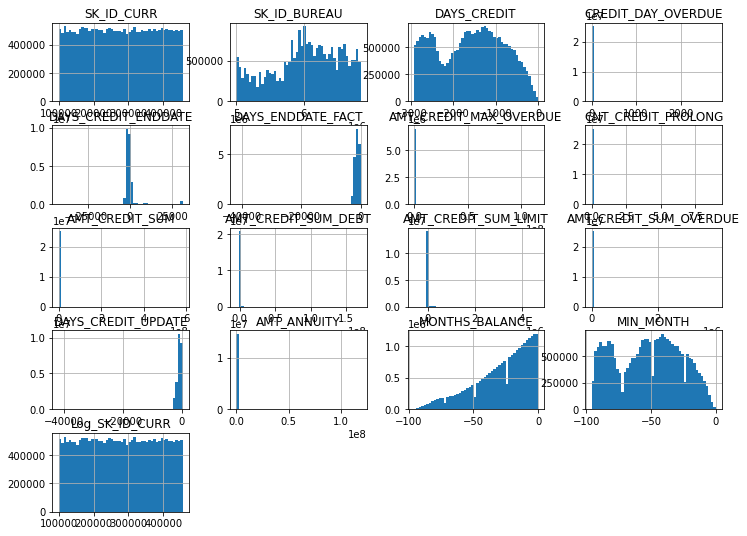

In [73]:
transform_flag_variables (df_bureau)
#histogramme
df_bureau[get_numerical_categorical(df_bureau)[0]].hist(bins=50, figsize= (12,9))
plt.show()


In [75]:
B= df_bureau.copy()

In [76]:
# FEATURE 1 - NUMBER OF PAST LOANS PER CUSTOMER

grp = B[['SK_ID_CURR', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index().rename(index=str, columns={'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
print(B.shape)

(25121815, 22)


In [77]:
B['BUREAU_LOAN_COUNT'].unique()

array([  11,    6,    1, ..., 1353, 1118, 1373], dtype=int64)

In [78]:
# FEATURE 2 - NUMBER OF TYPES OF PAST LOANS PER CUSTOMER

#B = df_bureau.copy()
grp = B[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
print(B.shape)

(25121815, 23)


In [79]:
B['BUREAU_LOAN_TYPES'].unique()

array([3, 1, 2, 4, 5, 6], dtype=int64)

In [80]:
# FEATURE 3 - AVERAGE NUMBER OF PAST LOANS PER TYPE PER CUSTOMER
print(B.columns)
# Average Number of Loans per Loan Type
B['AVERAGE_LOAN_TYPE'] = B['BUREAU_LOAN_COUNT']/B['BUREAU_LOAN_TYPES']
del B['BUREAU_LOAN_COUNT'], B['BUREAU_LOAN_TYPES']
import gc
gc.collect()
print(B.shape)


Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'MONTHS_BALANCE', 'STATUS', 'MIN_MONTH',
       'Log_SK_ID_CURR', 'BUREAU_LOAN_COUNT', 'BUREAU_LOAN_TYPES'],
      dtype='object')
(25121815, 22)


In [81]:
print(B['AVERAGE_LOAN_TYPE' ].unique())

[  3.66666667   2.           1.         ... 745.          22.25
 418.5       ]


In [82]:
B['AVERAGE_LOAN_TYPE' ].head(10)

0    3.666667
1    3.666667
2    3.666667
3    3.666667
4    3.666667
5    3.666667
6    3.666667
7    2.000000
8    2.000000
9    2.000000
Name: AVERAGE_LOAN_TYPE, dtype: float64

In [83]:
# FEATURE 4 - % OF ACTIVE LOANS FROM BUREAU DATA

# Create a new dummy column for whether CREDIT is ACTIVE OR CLOED 
B['CREDIT_ACTIVE_BINARY'] = B['CREDIT_ACTIVE']
B['CREDIT_ACTIVE_BINARY'] = B.apply(lambda x: convert_status(x.CREDIT_ACTIVE), axis = 1)

# Calculate mean number of loans that are ACTIVE per CUSTOMER 
grp = B.groupby(by = ['SK_ID_CURR'])['CREDIT_ACTIVE_BINARY'].mean().reset_index().rename(index=str, columns={'CREDIT_ACTIVE_BINARY': 'ACTIVE_LOANS_PERCENTAGE'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del B['CREDIT_ACTIVE_BINARY']
gc.collect()
print(B.shape)

(25121815, 23)


In [84]:
# FEATURE 5 AVERAGE NUMBER OF DAYS BETWEEN SUCCESSIVE PAST APPLICATIONS FOR EACH CUSTOMER

# Groupby each Customer and Sort values of DAYS_CREDIT in ascending order
grp = B[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])
grp1 = grp.apply(lambda x: x.sort_values(['DAYS_CREDIT'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
print("Grouping and Sorting done")

# Calculate Difference between the number of Days 
grp1['DAYS_CREDIT1'] = grp1['DAYS_CREDIT']*-1
grp1['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT1'].diff()
grp1['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')
del grp1['DAYS_CREDIT1'], grp1['DAYS_CREDIT'], grp1['SK_ID_CURR']
gc.collect()
print("Difference days calculated")

B = B.merge(grp1, on = ['SK_ID_BUREAU'], how = 'left')
print("Difference in Dates between Previous CB applications is CALCULATED ")
print(B.shape)

Grouping and Sorting done
Difference days calculated


MemoryError: Unable to allocate 8.81 GiB for an array with shape (1183019651,) and data type int64

In [85]:
# FEATURE 6 % of LOANS PER CUSTOMER WHERE END DATE FOR CREDIT IS PAST

#B = df_bureau.copy()
B['CREDIT_ENDDATE_BINARY'] = B['DAYS_CREDIT_ENDDATE']
B['CREDIT_ENDDATE_BINARY'] = B.apply(lambda x: normalize(x.DAYS_CREDIT_ENDDATE), axis = 1)
print("New Binary Column calculated")

grp = B.groupby(by = ['SK_ID_CURR'])['CREDIT_ENDDATE_BINARY'].mean().reset_index().rename(index=str, columns={'CREDIT_ENDDATE_BINARY': 'CREDIT_ENDDATE_PERCENTAGE'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')

del B['CREDIT_ENDDATE_BINARY']
gc.collect()
print(B.shape)

New Binary Column calculated
(25121815, 24)


In [86]:
print(B['CREDIT_ENDDATE_PERCENTAGE'].unique())
B['CREDIT_ENDDATE_PERCENTAGE'].head()



[0.54545455 0.16666667 1.         ... 0.31197772 0.25120773 0.24754902]


0    0.545455
1    0.545455
2    0.545455
3    0.545455
4    0.545455
Name: CREDIT_ENDDATE_PERCENTAGE, dtype: float64

In [87]:
# FEATURE 7 AVERAGE NUMBER OF DAYS IN WHICH CREDIT EXPIRES IN FUTURE -INDICATION OF CUSTOMER DELINQUENCY IN FUTURE??

# We take only positive values of  ENDDATE since we are looking at Bureau Credit VALID IN FUTURE 
# as of the date of the customer's loan application with Home Credit 
B1 = B[B['CREDIT_ENDDATE_BINARY'] == 1]
B1.shape

#Calculate Difference in successive future end dates of CREDIT 

# Create Dummy Column for CREDIT_ENDDATE 
B1['DAYS_CREDIT_ENDDATE1'] = B1['DAYS_CREDIT_ENDDATE']
# Groupby Each Customer ID 
grp = B1[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT_ENDDATE1']].groupby(by = ['SK_ID_CURR'])
# Sort the values of CREDIT_ENDDATE for each customer ID 
grp1 = grp.apply(lambda x: x.sort_values(['DAYS_CREDIT_ENDDATE1'], ascending = True)).reset_index(drop = True)
del grp
gc.collect()
print("Grouping and Sorting done")

# Calculate the Difference in ENDDATES and fill missing values with zero 
grp1['DAYS_ENDDATE_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT_ENDDATE1'].diff()
grp1['DAYS_ENDDATE_DIFF'] = grp1['DAYS_ENDDATE_DIFF'].fillna(0).astype('uint32')
del grp1['DAYS_CREDIT_ENDDATE1'], grp1['SK_ID_CURR']
gc.collect()
print("Difference days calculated")

# Merge new feature 'DAYS_ENDDATE_DIFF' with original Data frame for BUREAU DATA
B = B.merge(grp1, on = ['SK_ID_BUREAU'], how = 'left')
del grp = B[['SK_ID_CURR', 'DAYS_ENDDATE_DIFF']].groupby(by = ['SK_ID_CURR'])['DAYS_ENDDATE_DIFF'].mean().reset_index().rename( index = str, columns = {'DAYS_ENDDATE_DIFF': 'AVG_ENDDATE_FUTURE'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
#del B['DAYS_ENDDATE_DIFF']
del B['CREDIT_ENDDATE_BINARY'], B['DAYS_CREDIT_ENDDATE']
gc.collect()
print(B.shape)grp1
gc.collect()

# Calculate Average of DAYS_ENDDATE_DIFF

grp = B[['SK_ID_CURR', 'DAYS_ENDDATE_DIFF']].groupby(by = ['SK_ID_CURR'])['DAYS_ENDDATE_DIFF'].mean().reset_index().rename( index = str, columns = {'DAYS_ENDDATE_DIFF': 'AVG_ENDDATE_FUTURE'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
#del B['DAYS_ENDDATE_DIFF']
del B['CREDIT_ENDDATE_BINARY'], B['DAYS_CREDIT_ENDDATE']
gc.collect()
print(B.shape)

SyntaxError: invalid syntax (<ipython-input-87-a076deaf241e>, line 29)

In [ ]:
# FEATURE 8 - DEBT OVER CREDIT RATIO

B[~B['AMT_CREDIT_SUM_LIMIT'].isnull()][0:2]

# WE can see in the Table Below 
# AMT_CREDIT_SUM = AMT_CREDIT_SUM_DEBT + AMT_CREDIT_SUM_LIMIT
#B = df_bureau.copy()

B['AMT_CREDIT_SUM_DEBT'] = B['AMT_CREDIT_SUM_DEBT'].fillna(0)
B['AMT_CREDIT_SUM'] = B['AMT_CREDIT_SUM'].fillna(0)

grp1 = B[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
grp2 = B[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM': 'TOTAL_CUSTOMER_CREDIT'})

B = B.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
B = B.merge(grp2, on = ['SK_ID_CURR'], how = 'left')
del grp1, grp2
gc.collect()

B['DEBT_CREDIT_RATIO'] = B['TOTAL_CUSTOMER_DEBT']/B['TOTAL_CUSTOMER_CREDIT']

del B['TOTAL_CUSTOMER_DEBT'], B['TOTAL_CUSTOMER_CREDIT']
gc.collect()
print(B.shape)

In [ ]:
# FEATURE 9 - OVERDUE OVER DEBT RATIO

B['AMT_CREDIT_SUM_DEBT'] = B['AMT_CREDIT_SUM_DEBT'].fillna(0)
B['AMT_CREDIT_SUM_OVERDUE'] = B['AMT_CREDIT_SUM_OVERDUE'].fillna(0)

grp1 = B[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
grp2 = B[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})

B = B.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
B = B.merge(grp2, on = ['SK_ID_CURR'], how = 'left')
del grp1, grp2
gc.collect()

B['OVERDUE_DEBT_RATIO'] = B['TOTAL_CUSTOMER_OVERDUE']/B['TOTAL_CUSTOMER_DEBT']

del B['TOTAL_CUSTOMER_OVERDUE'], B['TOTAL_CUSTOMER_DEBT']
gc.collect()
print(B.shape)

In [88]:
# FEATURE 10 - AVERAGE NUMBER OF LOANS PROLONGED

B['CNT_CREDIT_PROLONG'] = B['CNT_CREDIT_PROLONG'].fillna(0)
grp = B[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']].groupby(by = ['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index().rename( index = str, columns = { 'CNT_CREDIT_PROLONG': 'AVG_CREDITDAYS_PROLONGED'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
print(B.shape)

(25121815, 25)


In [89]:
df_credit_card_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.827686e+04,1.538080e+05,5.962299e+03,7.432263e+03,2.881647e+02,2.968840e+03,3.541778e+03,...,5.595036e+04,5.808502e+04,5.809459e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.080733e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.074641e+05,1.651457e+05,2.803397e+04,3.336682e+04,8.197021e+03,2.066321e+04,5.525350e+03,...,1.015177e+05,1.071769e+05,1.071802e+05,1.088881e+00,3.190347e+00,8.250048e-02,3.212287e+00,2.001166e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


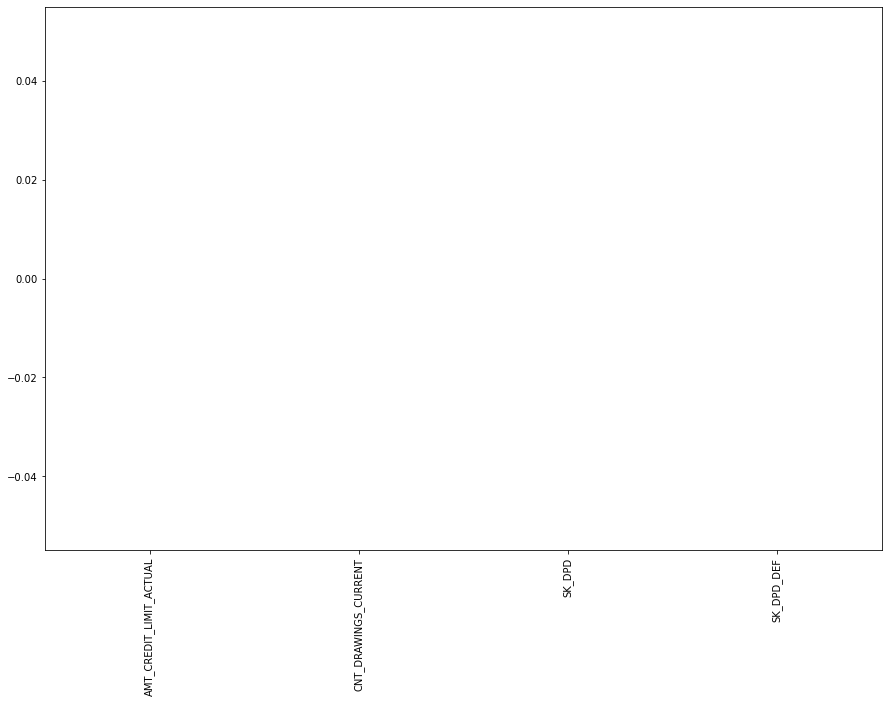

In [90]:
show_null_per_variable(df_credit_card_balance[get_numerical_categorical(df_credit_card_balance)[0]])

In [92]:
df_credit_card_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0


In [95]:
null_ratio(df_credit_card_balance)

Valeurs nulles: 5877356
Valeurs non nulles : 82449820
Pourcentage des valeurs nulles : 6.654074392687479%


In [96]:
get_dtypes(df_credit_card_balance)

int32
int32
int64
float32
int64
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
int64
float32
float32
float32
category
int64
int64


In [97]:
df_credit_card_balance.shape

(3840312, 23)

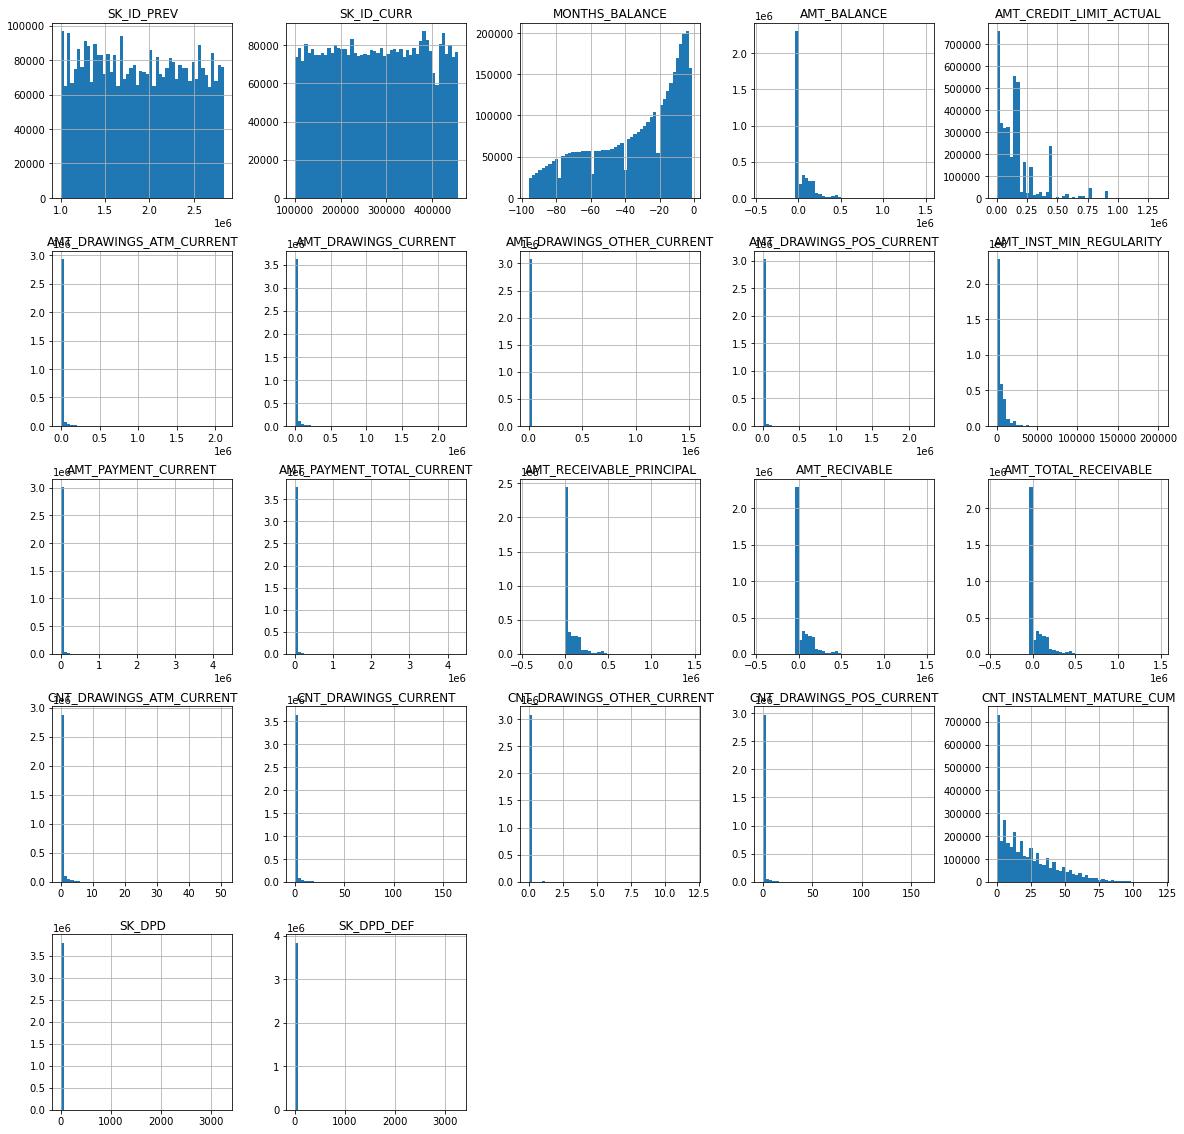

replace credit outliers


(3840312, 23)

In [100]:
df_credit_card_balance = pd.read_csv(directory+"credit_card_balance.csv", error_bad_lines=False, sep=',')

transform_flag_variables (df_credit_card_balance)
#histogrammes
df_credit_card_balance[get_numerical_categorical(df_credit_card_balance)[0]].hist(bins=50, figsize= (20,20))
plt.show()

print("replace credit outliers")  
#df_credit_card_balance = find_remove_outliers(df_credit_card_balance)
df_credit_card_balance.shape

#transform_variables_log(df_credit_card_balance, get_numerical_categorical(df_credit_card_balance)[0])
#label_encoded_credit, one_hot_encoded_credit = get_label_one_hot_columns (df_credit_card_balance)
#one_hot_encoder(enc, df_credit_card_balance, get_numerical_categorical(df_credit_card_balance)[1])
#label_encoder(labelencoder, df_credit_card_balance, label_encoded_credit)

In [101]:
#FEATURE 1 - NUMBER OF LOANS PER CUSTOMER
CCB = df_credit_card_balance[0:]
grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NO_LOANS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()
print(CCB.dtypes, CCB.shape)

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
NO_LOANS                        int64
dtype: object (3840312, 24)


In [102]:
#FEATURE 2 - RATE OF PAYBACK OF LOANS - NO OF INSTALMENTS PAID BY CUSTOMER PER LOAN

# CNT_INSTALMENT_MATURE_CUM gives number of installments paid as of that month 
# The Max of this column shows the total number of installments made for that loan 
CCB = df_credit_card_balance[0:]
grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NO_LOANS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

print(CCB.dtypes)


# No of Installments paid per Loan per Customer 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'NO_INSTALMENTS'})
grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'NO_INSTALMENTS': 'TOTAL_INSTALMENTS'})
CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp, grp1
gc.collect()

# Average Number of installments paid per loan 

CCB['INSTALLMENTS_PER_LOAN'] = (CCB['TOTAL_INSTALMENTS']/CCB['NO_LOANS']).astype('uint32')
del CCB['TOTAL_INSTALMENTS']
del CCB['NO_LOANS']
gc.collect()

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
NO_LOANS                        int64
dtype: object
SK_ID_PREV                      int64
SK_ID_CURR                      int6

In [103]:
#FEATURE 3 - AVG % LOADING OF CREDIT LIMIT PER CUSTOMER : HOW BADLY DID THE CUSTOMER NEED THE LOAN?

CCB['AMT_CREDIT_LIMIT_ACTUAL1'] = CCB['AMT_CREDIT_LIMIT_ACTUAL']

# Calculate the ratio of Amount Balance to Credit Limit - CREDIT LOAD OF CUSTOMER 
# This is done for each Credit limit value per loan per Customer 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL']).apply(lambda x: balance_limit(x.AMT_BALANCE, x.AMT_CREDIT_LIMIT_ACTUAL1)).reset_index().rename(index = str, columns = {0: 'CREDIT_LOAD1'})
del CCB['AMT_CREDIT_LIMIT_ACTUAL1']
gc.collect()

# We now calculate the mean Credit load of All Loan transactions of Customer 
grp1 = grp.groupby(by = ['SK_ID_CURR'])['CREDIT_LOAD1'].mean().reset_index().rename(index = str, columns = {'CREDIT_LOAD1': 'CREDIT_LOAD'})
print(grp1.dtypes)

CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp, grp1
gc.collect()

print(CCB.dtypes, CCB.shape)

ZeroDivisionError: float division by zero

In [104]:
#FEATURE 4 - AVERAGE NUMBER OF TIMES DAYS PAST DUE HAS OCCURRED PER CUSTOMER
# Function to calculate number of times Days Past Due occurred 

grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: DPD(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NO_DPD'})
grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_DPD'].mean().reset_index().rename(index = str, columns = {'NO_DPD' : 'DPD_COUNT'})

CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
del grp1
del grp 
gc.collect()

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
INSTALLMENTS_PER_LOAN          uint32
AMT_CREDIT_LIMIT_ACTUAL1        int64
DPD_COUNT                     float64
dtype: objec

In [105]:
#FEATURE 5 - AVERAGE OF DAYS PAST DUE PER CUSTOMER

grp = CCB.groupby(by= ['SK_ID_CURR'])['SK_DPD'].mean().reset_index().rename(index = str, columns = {'SK_DPD': 'AVG_DPD'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
INSTALLMENTS_PER_LOAN          uint32
AMT_CREDIT_LIMIT_ACTUAL1        int64
DPD_COUNT                     float64
AVG_DPD     

In [106]:
#FEATURE 6 - % of MINIMUM PAYMENTS MISSED

grp = CCB.groupby(by = ['SK_ID_CURR']).apply(lambda x: count_transaction(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'PERCENTAGE_MISSED_PAYMENTS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
INSTALLMENTS_PER_LOAN          uint32
AMT_CREDIT_LIMIT_ACTUAL1        int64
DPD_COUNT                     float64
AVG_DPD     

In [107]:
#FEATURE 7 - RATIO OF CASH VS CARD SWIPES
#IF A CUSTOMER IS USING CREDIT CARDS FOR CASH WITHDRAWALS - IS IT A RED FLAG ??


grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'DRAWINGS_ATM'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'DRAWINGS_TOTAL'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

CCB['CASH_CARD_RATIO1'] = (CCB['DRAWINGS_ATM']/CCB['DRAWINGS_TOTAL'])*100
del CCB['DRAWINGS_ATM']
del CCB['DRAWINGS_TOTAL']
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'CASH_CARD_RATIO1' : 'CASH_CARD_RATIO'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

del CCB['CASH_CARD_RATIO1']
gc.collect()

print(CCB.dtypes, CCB.shape)

# WE can leave NaN values as they are for LGBM 

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
INSTALLMENTS_PER_LOAN          uint32
AMT_CREDIT_LIMIT_ACTUAL1        int64
DPD_COUNT                     float64
AVG_DPD     

In [108]:
# FEATURE 8 - AVERAGE DRAWING PER CUSTOMER

grp = CCB.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'TOTAL_DRAWINGS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'NO_DRAWINGS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp
gc.collect()

CCB['DRAWINGS_RATIO1'] = (CCB['TOTAL_DRAWINGS']/CCB['NO_DRAWINGS'])*100
del CCB['TOTAL_DRAWINGS']
del CCB['NO_DRAWINGS']
gc.collect()

grp = CCB.groupby(by = ['SK_ID_CURR'])['DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'DRAWINGS_RATIO1' : 'DRAWINGS_RATIO'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')
del grp 
gc.collect()

del CCB['DRAWINGS_RATIO1']

print(CCB.dtypes, CCB.shape)

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
INSTALLMENTS_PER_LOAN          uint32
AMT_CREDIT_LIMIT_ACTUAL1        int64
DPD_COUNT                     float64
AVG_DPD     

In [109]:
df_installments_payments.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.024620e+03,-1.033598e+03,1.675076e+04,1.691504e+04
std,5.362029e+05,1.027183e+05,1.033389e+00,2.666407e+01,7.961519e+02,7.956160e+02,4.964295e+04,5.375981e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [111]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [113]:
null_ratio(df_installments_payments)

Valeurs nulles: 5810
Valeurs non nulles : 108837398
Pourcentage des valeurs nulles : 0.005337953655316738%


In [114]:
get_dtypes(df_installments_payments)

int32
int32
float32
int64
float32
float32
float32
float32


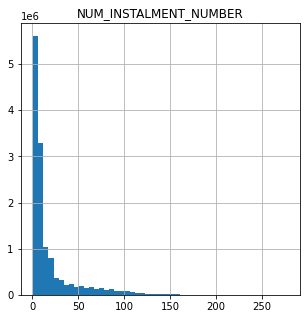

replace installment outliers


(13605401, 8)

In [116]:
transform_flag_variables (df_installments_payments)
#histogrammes
df_installments_payments[get_numerical_categorical(df_installments_payments)[0]].hist(bins=50, figsize= (5,5))
plt.show()

print("replace installment outliers")  
#df_installments_payments = find_remove_outliers(df_installments_payments)
df_installments_payments.shape

#transform_variables_log(df_installments_payments, get_numerical_categorical(df_installments_payments)[0])
#label_encoded_ins, one_hot_encoded_ins = get_label_one_hot_columns (df_installments_payments)
#one_hot_encoder(enc, df_installments_payments, one_hot_encoded_ins)
#label_encoder(labelencoder, df_installments_payments, label_encoded_ins)

In [117]:
df_installments_payments['DIFF_DAYS_INS_PAY'] = df_installments_payments['DAYS_INSTALMENT'] - df_installments_payments['DAYS_ENTRY_PAYMENT']
df_installments_payments['DIFF_AMT_INS_PAY'] = df_installments_payments['AMT_INSTALMENT'] - df_installments_payments['AMT_PAYMENT']

In [118]:
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DIFF_DAYS_INS_PAY,DIFF_AMT_INS_PAY
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863,7.0,0.000000
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024,0.0,0.000000
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000,0.0,0.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859,8.0,0.000000
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961,-17.0,4.455078


In [119]:
df_POS_CASH_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.751403e+01,1.036928e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.151579e+01,1.101344e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [121]:
df_POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [122]:
get_dtypes(df_POS_CASH_balance)

int32
int32
int64
float32
float32
category
int64
int64


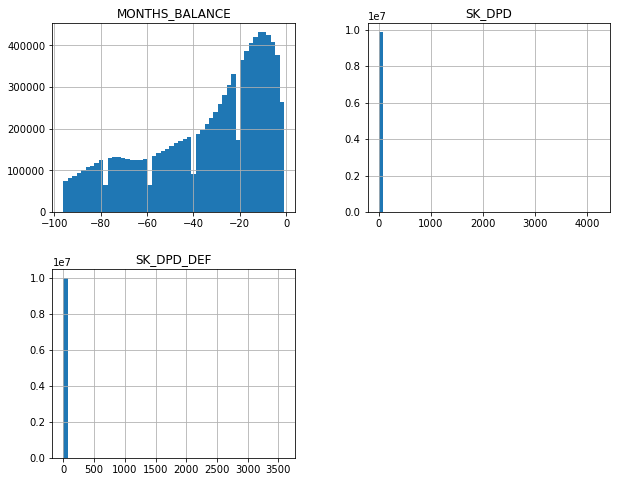

replace POS_CASH outliers


(10001358, 8)

In [125]:
transform_flag_variables (df_POS_CASH_balance)
#histogrammes
df_POS_CASH_balance[get_numerical_categorical(df_POS_CASH_balance)[0]].hist(bins=50, figsize= (10,8))
plt.show()

print("replace POS_CASH outliers")  
#df_POS_CASH_balance = find_remove_outliers(df_POS_CASH_balance)
df_POS_CASH_balance.shape

#transform_variables_log(df_POS_CASH_balance, get_numerical_categorical(df_POS_CASH_balance)[0])
#label_encoded_pos, one_hot_encoded_pos = get_label_one_hot_columns (df_POS_CASH_balance)
#one_hot_encoder(enc, df_POS_CASH_balance, one_hot_encoded_pos)
#label_encoder(labelencoder, df_POS_CASH_balance, label_encoded_pos)

In [126]:
df_previous_application.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,774370.000000,5951.000000,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.00000,997149.000000
mean,1.923089e+06,2.783572e+05,1.594889e+04,1.749806e+05,1.960131e+05,6.699080e+03,2.275182e+05,1.248418e+01,0.079712,0.188360,0.773517,-8.806797e+02,3.139511e+02,1.605409e+01,340114.343750,13838.132812,33764.871094,76829.148438,82314.84375,0.332570
std,5.325980e+05,1.028148e+05,1.477695e+04,2.933005e+05,3.177837e+05,2.090572e+04,3.154605e+05,3.334028e+00,0.107919,0.087671,0.100879,7.790997e+02,7.127443e+03,1.454715e+01,88611.609375,72421.296875,106544.812500,150155.109375,152926.93750,0.471501
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,-0.000015,0.034781,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.00000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,0.000000,0.160716,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.00000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,0.051605,0.189122,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.00000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,0.108909,0.193330,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.00000,1.000000
max,2.845382e+06,4.562550e+05,4.180582e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000,1.000000,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.00000,1.000000


In [127]:
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
null_ratio(df_previous_application)

Valeurs nulles: 11109336
Valeurs non nulles : 50688582
Pourcentage des valeurs nulles : 17.97687747344498%


In [129]:
get_dtypes(df_previous_application)

int32
int32
category
float32
float32
float32
float32
float32
category
int64
category
bool
float32
float32
float32
category
category
int64
category
category
category
category
category
category
category
category
int64
category
float32
category
category
float32
float32
float32
float32
float32
float32


[2030495 2802425 2523466 ... 2659632 2785582 2418762]
[271877 108129 122040 ... 253940 353284 191629]
['Consumer loans', 'Cash loans', 'Revolving loans', 'XNA']
Categories (4, object): ['Consumer loans', 'Cash loans', 'Revolving loans', 'XNA']
[ 1730.43  25188.615 15060.735 ... 15708.15   8546.94  14704.29 ]
[ 17145.   607500.   112500.   ... 332596.1  373230.72 267295.5 ]
[ 17145.   679671.   136444.5  ... 977724.   626796.   436370.22]
[    0.        nan 12649.5  ...  4099.95 55325.25 50476.5 ]
[ 17145.   607500.   112500.   ... 332596.1  373230.72 267295.5 ]
['SATURDAY', 'THURSDAY', 'TUESDAY', 'MONDAY', 'FRIDAY', 'SUNDAY', 'WEDNESDAY']
Categories (7, object): ['SATURDAY', 'THURSDAY', 'TUESDAY', 'MONDAY', 'FRIDAY', 'SUNDAY', 'WEDNESDAY']
['Y', 'N']
Categories (2, object): ['Y', 'N']
[ True False]
[0.                nan 0.10397129 ... 0.01249714 0.10340195 0.04430024]
[0.18283181        nan 0.19691432 0.18913634 0.69566756 0.19175734
 0.18912219 0.19332993 0.16071631 0.19690014 0.1828

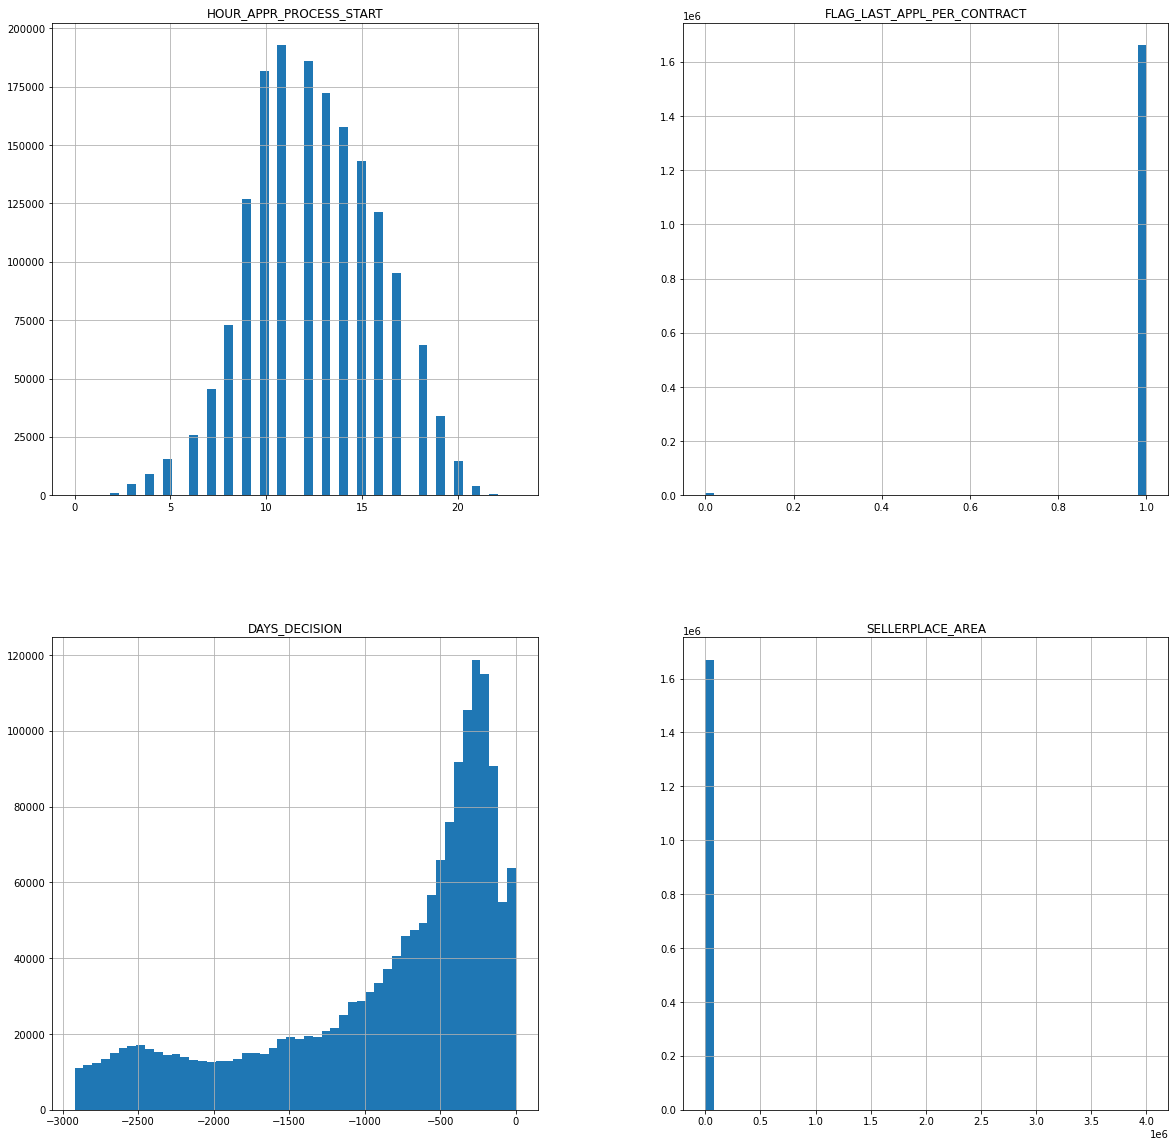

replace previous application outliers


(1670214, 37)

In [131]:
cat_prev_app = get_numerical_categorical(df_previous_application)[1]
for c in cat_prev_app :
    print(df_previous_application[c].unique())
transform_flag_variables (df_previous_application)
#histogrammes
df_previous_application[get_numerical_categorical(df_previous_application)[0]].hist(bins=50, figsize= (20,20))
plt.show()

print("replace previous application outliers")  
#df_previous_application = find_remove_outliers(df_previous_application)
df_previous_application.shape


In [132]:

transform_variables_log(df_previous_application, get_numerical_categorical(df_previous_application)[0])
#label_encoded_prev, one_hot_encoded_prev = get_label_one_hot_columns (df_previous_application)
one_hot_encoder(enc, df_previous_application, cat_prev_app)
#label_encoder(labelencoder, df_previous_application, label_encoded_prev)

MemoryError: Unable to allocate 2.54 TiB for an array with shape (1670214, 1670214) and data type uint8

In [ ]:
df_previous_application['PRODUCT_COMBINATION'].unique()

In [ ]:
df_previous_application ['DAY_PROCESS_START'] = [] # 0 si semaine,  1 si weekend 
df_previous_application ['HOUROCESS_START'] = [] # 0 si entre minuit et 7h et 1 sinon

In [ ]:
# normalize AMT application et AMT credit et AMT goods 
df_previous_application['AMT_DOWN_PAYMENT'].unique()
df_previous_application['DIFF_APP_CRE'] = df_previous_application['AMT_APPLICATION']/df_previous_application['AMT_CREDIT'] 
df_previous_application['DOWN_PERCENTAGE'] = df_previous_application['AMT_DOWN_PAYMENT'] /df_previous_application['AMT_CREDIT'] 
df_previous_application['DIFF_APP_GOODS'] = df_previous_application['AMT_APPLICATION']/df_previous_application['AMT_CREDIT']
df_previous_application['DIFF_CRE_GOODS'] = df_previous_application['AMT_CREDIT'] / df_previous_application['AMT_GOODS_PRICE']
df_previous_application['FLAG_DOWN'] = #1 si >0 0 sinon ou si nan

In [ ]:
df_previous_application[''] product_catacteristics.groupby(['SK_ID_CURR'])[''].transform('mean')
df_previous_application['DIFF_APP_CRE'] = df_previous_application.groupby(['SK_ID_CURR'])['DIFF_APP_CRE'].transform('mean') 
df_previous_application['DOWN_PERCENTAGE'] = df_previous_application.groupby(['SK_ID_CURR'])['DOWN_PERCENTAGE'].transform('mean') 
df_previous_application['DIFF_APP_GOODS'] = df_previous_application.groupby(['SK_ID_CURR'])['DIFF_APP_GOODS'].transform('mean')
df_previous_application['DIFF_CRE_GOODS'] = df_previous_application.groupby(['SK_ID_CURR'])['DIFF_CRE_GOODS'].transform('mean')
df_previous_application['FLAG_DOWN'] = df_previous_application.groupby(['SK_ID_CURR'])['FLAG_DOWN'].transform('max')

In [ ]:
df_sample_submission.describe()

In [ ]:
primary_key_columns (df_sample_submission)

In [ ]:
df_sample_submission.head()

In [ ]:
get_dtypes(df_sample_submission)

In [ ]:
df_sample_submission.shape

In [ ]:
transform_flag_variables (df_sample_submission)
#histogrammes
df_sample_submission[get_numerical_categorical(df_sample_submission)[0]].hist(bins=50, figsize= (20,20))
plt.show()

print("replace POS_CASH outliers")  
#df_sample_submission = find_remove_outliers(df_sample_submission)
df_sample_submission.shape

transform_variables_log(df_sample_submission, get_numerical_categorical(df_sample_submission)[0])
label_encoded_sam, one_hot_encoded_sam = get_label_one_hot_columns (df_sample_submission)
one_hot_encoder(enc, df_sample_submission, one_hot_encoded_sam)
label_encoder(labelencoder, df_sample_submission, label_encoded_sam)

In [ ]:
#df_bureau = find_remove_outliers(df_bureau)
#df_bureau.shape

transform_variables_log(df_bureau, get_numerical_categorical(df_bureau)[0])
#label_encoded_bureau, one_hot_encoded_bureau = get_label_one_hot_columns (df_bureau)
#one_hot_encoder(enc, df_bureau, get_numerical_categorical(df_bureau)[0])
#label_encoder(labelencoder, df_bureau, label_encoded_bureau)
B = df_bureau.copy()

In [ ]:
train = train.merge(B, on = ['SK_ID_CURR'], how = 'left')
train = train.merge(CCB, on = ['SK_ID_CURR'], how = 'left')

test = test.merge(B, on = ['SK_ID_CURR'], how = 'left')
test = test.merge(CCB, on = ['SK_ID_CURR'], how = 'left')

In [ ]:
IC = df_installments_payments.copy()
PC = df_POS_CASH_balance.copy()
PA = df_previous_application.copy()
SS = df_sample_submission.copy()

In [ ]:

PA = PA.merge(IC,on = ['SK_ID_PREV'], how = 'left')
PA = PA.merge(PC ,on = ['SK_ID_PREV'], how = 'left')
# agregation on columns 
PA.head()
#merge count variables

#merging rate variables 

#merging amout variables


del IC
del PC
gc.collect()


In [ ]:
train = train.merge(PA, on = ['SK_ID_PREV'], how = 'left')
test = test.merge(PA, on = ['SK_ID_PREV'], how = 'left')
# agregation on columns 
train.head()
#merge count variables

#merging rate variables 

#merging amout variables

del PA
gc.collect()


In [ ]:

train = train.merge(SS, on = ['SK_ID_CURR'], how = 'left')
test = test.merge(SS, on = ['SK_ID_CURR'], how = 'left')
# agregation on columns 
train.head()
#merge count variables

#merging rate variables 

#merging amout variables

del ss
gc.collect()


In [ ]:
null_ratio(train)

In [133]:
train.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0.0,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1.0,1.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,0
5,100008,0,0.0,1.0,0,99000.0,490495.5,27517.5,454500.0,0.035792,...,0,0,0,0,0,0,0,0,0,0
6,100009,0,1.0,1.0,1,171000.0,1560726.0,41301.0,1395000.0,0.035792,...,0,0,0,0,0,0,0,0,0,0
7,100010,0,1.0,1.0,0,360000.0,1530000.0,42075.0,1530000.0,0.003122,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
null_ratio(test)

In [ ]:
test.head()

In [ ]:
 # normalize values
std_scale = preprocessing.StandardScaler().fit(train)
X_scaled = std_scale.transform(train)

## Handle class inbalance with SMOTE 

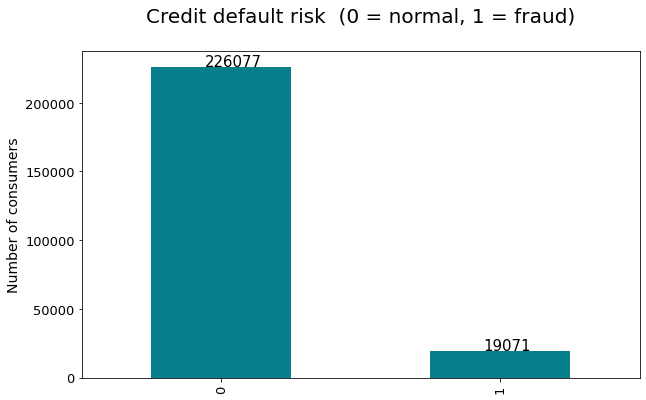

In [136]:
ax = train['TARGET'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Credit default risk  (0 = normal, 1 = default)', size=20, pad=30)
ax.set_ylabel('Number of consumers', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)


In [143]:
from imblearn.over_sampling import SMOTE 
def handle_unbalanced_data(X, y):
    sm = SMOTE(random_state=42)
    X_sm, y_sm = sm.fit_resample(X, y)

    print(f'''Shape of X before SMOTE: {X.shape}
    Shape of X after SMOTE: {X_sm.shape}''')

    print('\nBalance of positive and negative classes (%):')
    y_sm.value_counts(normalize=True) * 100
    X= X_sm
    y= y_sm
    return 

In [144]:
#new dataset values
target = ['TARGET']

elements = [ele for ele in train.columns if ele not in target]
handle_unbalanced_data(train[elements], train['TARGET'] )
#handle_unbalanced_data(test)



Shape of X before SMOTE: (245148, 205)
    Shape of X after SMOTE: (452154, 205)

Balance of positive and negative classes (%):


(        SK_ID_CURR  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
 0           100002      0.000000         1.000000             0   
 1           100004      1.000000         1.000000             0   
 2           100008      0.000000         1.000000             0   
 3           100009      1.000000         1.000000             1   
 4           100010      1.000000         1.000000             0   
 ...            ...           ...              ...           ...   
 452149      366814      0.000000         1.000000             0   
 452150      220237      0.558607         0.441393             0   
 452151      125059      0.000000         0.751876             0   
 452152      355604      0.253756         1.000000             2   
 452153      264899      0.000000         0.943907             0   
 
         AMT_INCOME_TOTAL    AMT_CREDIT   AMT_ANNUITY  AMT_GOODS_PRICE  \
 0          202500.000000  4.065975e+05  24700.500000     3.510000e+05   
 1           67500.000000  1.35000

In [145]:
train.shape

(245148, 206)

In [ ]:
test.shape

## Client Classification 
* we compute a score representing risks related to the client profile and we deduce wether the client should be given or not the loan --> the score represents a probability 
### Examples with pycaret

In [147]:
from pycaret.classification import * 
#setting the experiment
reg_experiment = setup(train, 
                       target = 'TARGET', 
                       session_id=123, 
                       log_experiment=True, 
                       experiment_name='ca_banking')

,Description,Value
0,session_id,123
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(245148, 206)"
5,Missing Values,False
6,Numeric Features,131
7,Categorical Features,74
8,Ordinal Features,False
9,High Cardinality Features,False


In [148]:
#best_model = compare_models(exclude=['xgboost'], fold=5)
best_model = compare_models(exclude=[], fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9216,0.7484,0.0176,0.5231,0.0340,0.0290,0.0849,29.1260
lr,Logistic Regression,0.9215,0.6107,0.0000,0.0000,0.0000,0.0000,0.0000,11.1900
ridge,Ridge Classifier,0.9215,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0003,0.3400
rf,Random Forest Classifier,0.9215,0.7135,0.0013,0.6200,0.0027,0.0023,0.0257,18.7400
ada,Ada Boost Classifier,0.9215,0.7431,0.0212,0.5027,0.0407,0.0346,0.0908,6.3260
et,Extra Trees Classifier,0.9215,0.7028,0.0006,0.4633,0.0012,0.0010,0.0148,28.2740
lightgbm,Light Gradient Boosting Machine,0.9215,0.7490,0.0151,0.5060,0.0294,0.0248,0.0766,1.6160
lda,Linear Discriminant Analysis,0.9212,0.7459,0.0240,0.4619,0.0457,0.0382,0.0913,2.8540
xgboost,Extreme Gradient Boosting,0.9207,0.7385,0.0328,0.4355,0.0610,0.0505,0.1023,22.4280
knn,K Neighbors Classifier,0.9166,0.5258,0.0102,0.1237,0.0188,0.0069,0.0135,7.4280


In [149]:
def create_tune_model(model_name):
    model  = create_model(model_name)
    tuned_model = tune_model(model, n_iter=50, optimize = 'MAE')
    print('Residual Plot')
    plot_model(tuned_model)
    print('Prediction Error')
    plot_model(tuned_model, plot = 'error')
    print('Feature Importances')
    plot_model(tuned_model, plot = 'feature')
    print('Model evaluation')
    evaluate_model(tuned_model)
    print('Model interpretation')
    interpret_model(tuned_model)
    

In [151]:
#linear models
#create_tune_model('ridge')
#create_tune_model('lasso')
#create_tune_model('en')

In [153]:
# Ridge alternatives
#create_tune_model( 'br') 
#create_tune_model('kr')

In [154]:
#kernel based model
create_tune_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8980,0.0000,0.0512,0.1273,0.0731,0.0293,0.0328
1,0.9213,0.0000,0.0000,0.0000,0.0000,-0.0002,-0.0032
2,0.9214,0.0000,0.0000,0.0000,0.0000,-0.0001,-0.0022
3,0.9215,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9214,0.0000,0.0000,0.0000,0.0000,-0.0002,-0.0032
5,0.9215,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9214,0.0000,0.0000,0.0000,0.0000,-0.0002,-0.0032
7,0.9215,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9215,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.9127,0.0000,0.0223,0.1422,0.0385,0.0176,0.0264


ValueError: Optimize method not supported. See docstring for list of available parameters.

In [ ]:
# nearest neighbor 
create_tune_model('knn')

In [ ]:
#decision tree models
create_tune_model('dt')
create_tune_model( 'rf') 

In [ ]:
# Boosting model
create_tune_model('ada')
create_tune_model('gbr')
create_tune_model('lightgbm') 
create_tune_model('xgboost')

In [155]:
model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9220,0.7546,0.0200,0.6000,0.0388,0.0339,0.0994
1,0.9217,0.7373,0.0148,0.5714,0.0289,0.0250,0.0828
2,0.9216,0.7507,0.0185,0.5319,0.0358,0.0307,0.0883
3,0.9220,0.7584,0.0186,0.5952,0.0360,0.0314,0.0952
4,0.9208,0.7416,0.0156,0.3889,0.0300,0.0241,0.0648
5,0.9217,0.7518,0.0141,0.5429,0.0275,0.0236,0.0781
6,0.9216,0.7355,0.0134,0.5143,0.0260,0.0222,0.0733
7,0.9214,0.7497,0.0163,0.4783,0.0316,0.0265,0.0771
8,0.9212,0.7669,0.0134,0.4390,0.0259,0.0214,0.0656
9,0.9209,0.7391,0.0156,0.4038,0.0300,0.0243,0.0667


 ## SHAP (SHapley Additive exPlanations)
* How To Calculate the Shapley Values for one feature?
* This value is the average marginal contribution of a feature value across all the possible combinations of features.

In [156]:
X = train[elements]
y = train['TARGET']

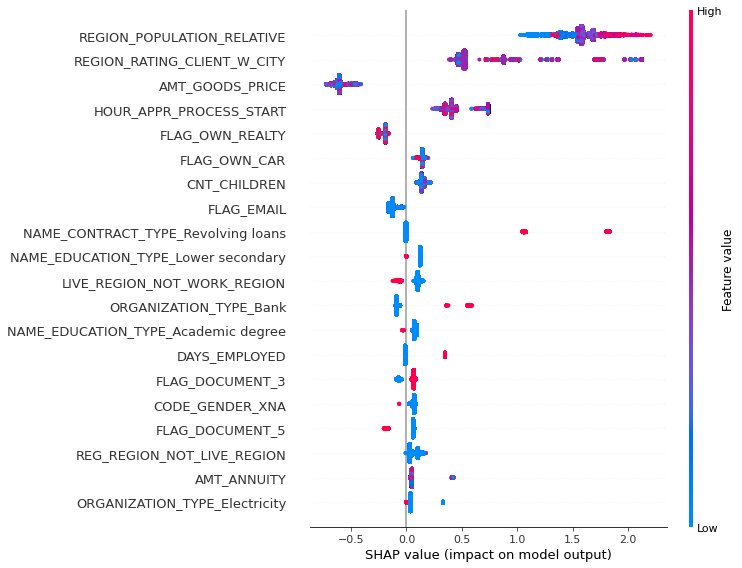

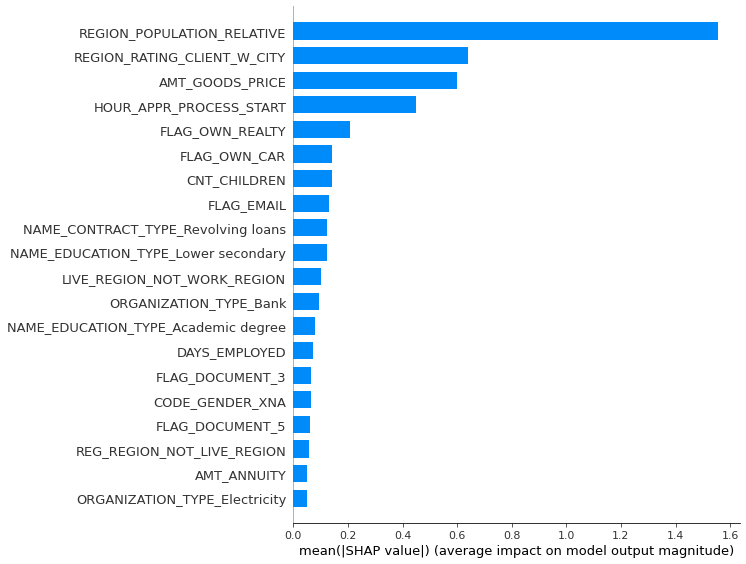

In [162]:
import shap
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')


In [ ]:
# roc curve and auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
model = LogisticRegression(solver='lbfgs')

def plot_roc_curve (ns_fpr, ns_tpr, lr_fpr, lr_tpr):
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

def roc_curve_aux (trainX, testX, trainy, testy, model) :

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]
    # fit a model by model name variable
    model.fit(trainX, trainy)
    # predict probabilities
    lr_probs = model.predict_proba(testX)
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        # calculate scores
        ns_auc = roc_auc_score(testy, ns_probs)
        lr_auc = roc_auc_score(testy, lr_probs)
        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Logistic: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
        #plot curve
        plot_roc_curve (ns_fpr, ns_tpr, lr_fpr, lr_tpr)

In [ ]:
### Precision-Recall Curves : used in case of class imbalance
#peut être ustilisée si on n'a pas appliqué SMOTE

In [ ]:
# precision-recall curve and f1

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## save model 

In [163]:
import pickle
# create an iterator object with write permission - model.pkl
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)

In [164]:
# load saved model
with open('model_pkl' , 'rb') as f:
    lr = pickle.load(f)

In [ ]:
# check prediction

lr.predict([[5000]]) # similar

## MLflow UI

In [ ]:
!mlflow ui

## Model Deployment

In [ ]:
aws configure

In [ ]:
deploy_model(automl_model, model_name = 'automl-model-aws', 
             platform='aws',
             authentication = {'bucket' : 'pycaret-ca-bank_score-model'})
